# List 4 of Machine Learning course

## Introduction

Unsupervised learning aims to uncover hidden patterns in data without the guidance of labeled examples.  A core task in this domain is clustering, where similar data points are grouped together. This notebook provides a practical introduction to clustering by implementing and comparing two widely used algorithms: `K-Means` and `DBSCAN`.  We will use the Abalone dataset to demonstrate these techniques, covering data analysis, algorithm execution, performance evaluation using metrics like Silhouette score and Davies-Bouldin index, visualization of cluster assignments, and an analysis of the influence of key hyperparameters.

**Dataset:** [Abalone](https://archive.ics.uci.edu/dataset/1/abalone)


## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
import sweetviz as sv

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.cluster import KMeans, DBSCAN
from ucimlrepo import fetch_ucirepo
import matplotlib.animation as animation

## Dataset Loading

In [2]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
display(X.head())
display(y.head())

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


,Rings
0,15
1,7
2,9
3,10
4,7


## Train test split

In [3]:
classes_with_one_sample = y['Rings'].value_counts()[y['Rings'].value_counts() == 1].index

# Separate instances with only one class
X_single_instances = X[y['Rings'].isin(classes_with_one_sample)]
y_single_instances = y[y['Rings'].isin(classes_with_one_sample)]

# Remove these instances from the original data
X_multi_instances = X[~y['Rings'].isin(classes_with_one_sample)]
y_multi_instances = y[~y['Rings'].isin(classes_with_one_sample)]

# Perform stratified split on the multi-instance data
X_train, X_test, y_train, y_test = train_test_split(X_multi_instances, y_multi_instances, test_size=0.3, random_state=42, stratify=y_multi_instances)

# Randomly shuffle the single-instance data
X_single_instances, y_single_instances = shuffle(X_single_instances, y_single_instances, random_state=42)

# Add the single-instance data to the training and test sets
num_train = int(len(X_single_instances) * 0.7)

X_train = pd.concat([X_train, X_single_instances[:num_train]])
y_train = pd.concat([y_train, y_single_instances[:num_train]])
X_test = pd.concat([X_test, X_single_instances[num_train:]])
y_test = pd.concat([y_test, y_single_instances[num_train:]])

## Auto EDA

In [4]:
df_train = pd.concat([X_train, y_train], axis=1)

In [5]:
report = False
if report:
    sweet_report = sv.analyze(df_train, target_feat='Rings')
    sweet_report.show_html('abalone_EDA.html')

### Conclusions

- As is also clear from the documentation, the data has no missing values.
- All but one column is numeric, this one has 3 values which will be coded 0, 1, 2.
- The distribution of rings is not even, the vast majority near 10.
- You can see a very strong positive correlation between the columns and between the columns and the target.

Because of the high correlation, it can be concluded that many features are redundant and can be removed. E.g. Diameter and Length have a very similar distribution and graph and a correlation of 0.99

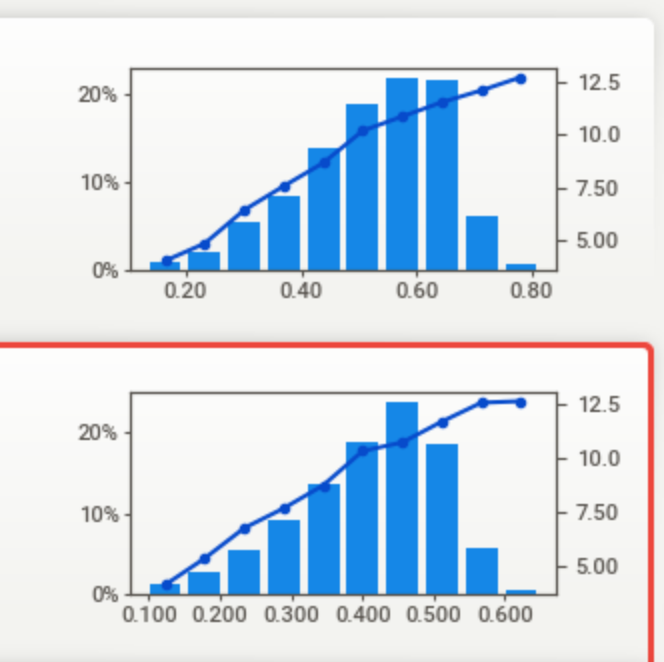

## Normalisation and encoding

In [6]:
X_train_df = X_train.copy()
X_test_df = X_test.copy()

In [7]:
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
minmax = MinMaxScaler()
X_train_norm = minmax.fit_transform(X_train[numeric_columns])
X_test_norm = minmax.transform(X_test[numeric_columns])

X_train_df[numeric_columns] = X_train_norm
X_test_df[numeric_columns] = X_test_norm

In [8]:
X_train_df['Sex'] = X_train_df['Sex'].replace({'M': 0, 'F': 1, 'I': 2})
X_test_df['Sex'] = X_test_df['Sex'].replace({'M': 0, 'F': 1, 'I': 2})

X_train_df = X_train_df.reset_index(drop=True)
X_test_df = X_test_df.reset_index(drop=True)

In [9]:
display(X_train_df.head())
display(X_test_df.head())

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,1,0.613139,0.603604,0.132743,0.232756,0.174587,0.157756,0.217174
1,0,0.583942,0.621622,0.181416,0.297761,0.212673,0.283828,0.241138
2,1,0.408759,0.378378,0.088496,0.127302,0.113920,0.082508,0.106340
3,1,0.773723,0.765766,0.176991,0.601481,0.450624,0.631023,0.445831
4,1,0.489051,0.468468,0.101770,0.166125,0.128750,0.152475,0.122317


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0,0.693431,0.630631,0.123894,0.350849,0.286485,0.271947,0.291063
1,2,0.408759,0.378378,0.088496,0.091730,0.064375,0.083168,0.081378
2,2,0.569343,0.558559,0.123894,0.204767,0.131783,0.188119,0.175237
3,2,0.343066,0.306306,0.119469,0.076201,0.067745,0.058746,0.056915
4,2,0.343066,0.315315,0.075221,0.076562,0.059993,0.066007,0.062406


## Training

### Parameter tuning

#### KMeans

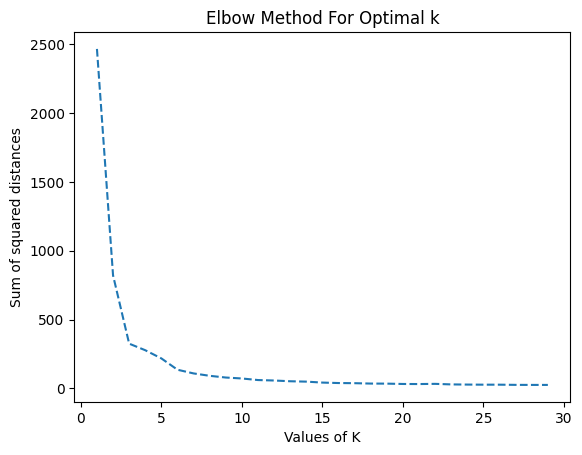

In [10]:
distances = []
K = range(1,30)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train_df)
    distances.append(kmeans.inertia_)
plt.plot(K, distances, linestyle='--')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal k')
plt.show()

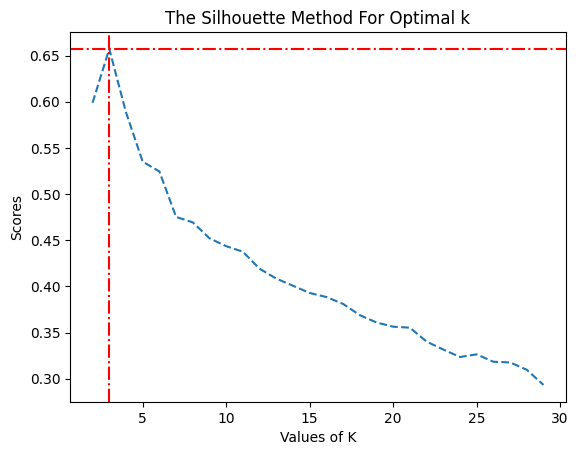

In [11]:
scores = []
K = range(2,30)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train_df)
    scores.append(silhouette_score(X_train_df, kmeans.labels_))
plt.plot(K, scores, linestyle='--')
plt.xlabel('Values of K') 
plt.ylabel('Scores')
plt.axhline(y=max(scores), color='r', linestyle='-.')
plt.axvline(x=scores.index(max(scores)) + 2, color='r', linestyle='-.')
plt.title('The Silhouette Method For Optimal k')
plt.show()

**It was decided to choose k=3**

#### DBSCAN

**How to determine DBSCAN values.
- min_samples >= D + 1, D- data dimensions (for us 8)
- epsilon elbow for k=min_samples-1 nearest neighbours, (for us 7)

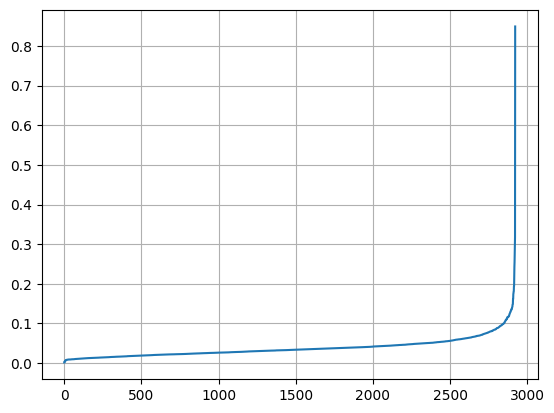

In [12]:
neighbors = NearestNeighbors(n_neighbors=7)
neighbors_fit = neighbors.fit(X_train_df)
distances, indices = neighbors_fit.kneighbors(X_train_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.yticks(np.arange(0, max(distances), 0.1))
plt.grid(True)
plt.show()

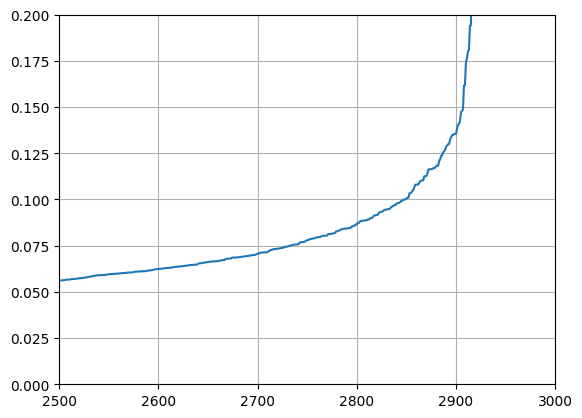

In [13]:
neighbors = NearestNeighbors(n_neighbors=7)
neighbors_fit = neighbors.fit(X_train_df)
distances, indices = neighbors_fit.kneighbors(X_train_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.ylim(0, 0.2)
plt.xlim(2500, 3000)
plt.plot(distances)
plt.grid(True)
plt.show()

**Min_samples=8 and epsilon=0.1 were selected.**

### Method Comparison

In [14]:
results = {}
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_df)
preds = kmeans.predict(X_test_df)

results['KMeans'] = {
    'Silhouette': silhouette_score(X_test_df, preds),
    'Davies-Bouldin': davies_bouldin_score(X_test_df, preds),
    'Calinski-Harabasz': calinski_harabasz_score(X_test_df, preds)
}

In [15]:
dbscan = DBSCAN(eps=0.1, min_samples=8)
dbscan.fit(X_train_df)
preds = dbscan.fit_predict(X_test_df)

results['DBSCAN'] = {
    'Silhouette': silhouette_score(X_test_df, preds),
    'Davies-Bouldin': davies_bouldin_score(X_test_df, preds),
    'Calinski-Harabasz': calinski_harabasz_score(X_test_df, preds)
}

In [16]:
display(pd.DataFrame(results).T)

,Silhouette,Davies-Bouldin,Calinski-Harabasz
KMeans,0.662240,0.526415,4371.246097
DBSCAN,0.594343,1.504459,2320.920277


### Conclusions

1. **Silhouettes** - both results are quite good, they are highly positive which indicates that the clusters are dense and well segregated. Surprisingly this is a measure that favours methods like DBSCAN, so it should get a better score.
2. **Calinski-Harabasz Index** - (*Variance Ratio Criterion*) - KMeans method has a higher score which means it has better defined clusters.
3. **Davies-Bouldin** - KMeans has a lower value, which means that the clusters are more distant and internally consistent than for the DBSCAN measure.

### Notes on measures:

1. **Silhouette** - This measures the consistency of data points within a cluster compared to the distance between them and points from other clusters. (It is good for selecting the number of clusters).
2. **Calinski-Harabasz** - It measures the consistency of data points within clusters compared to the distance between them and noise points.
3. **Davies-Bouldin** - This measures the distance between clusters relative to the average consistency within clusters.

## Visualisation of methods

### Visualisation for 2 variables

#### K-Means

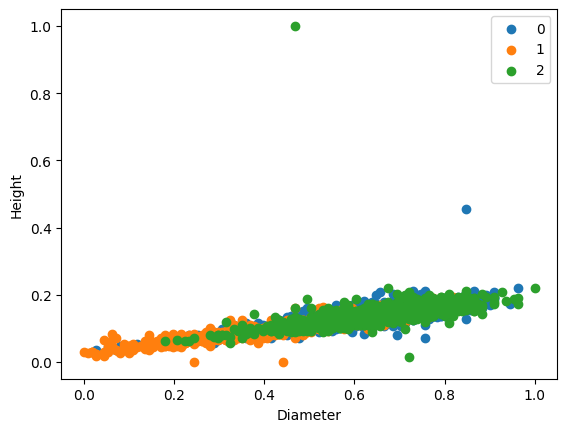

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_df)
labels = kmeans.predict(X_train_df)

u_labels = np.unique(labels)

for i in u_labels:
    plt.scatter(X_train_df[labels == i]['Diameter'], X_train_df[labels == i]['Height'], label=i)

plt.ylabel('Height')
plt.xlabel('Diameter')
plt.legend()
plt.show()

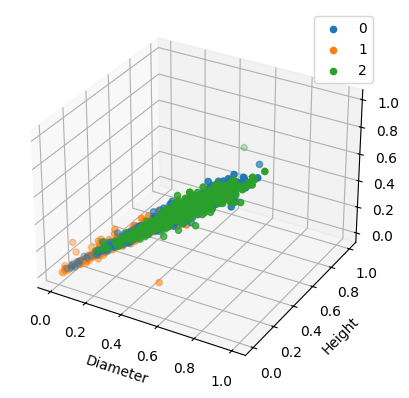

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in u_labels:
    ax.scatter(X_train_df[labels == i]['Diameter'], X_train_df[labels == i]['Height'], X_train_df[labels == i]['Length'], label=i)

ax.set_xlabel('Diameter')
ax.set_ylabel('Height')
ax.set_zlabel('Length')
plt.legend()
plt.show()

#### DBSCAN

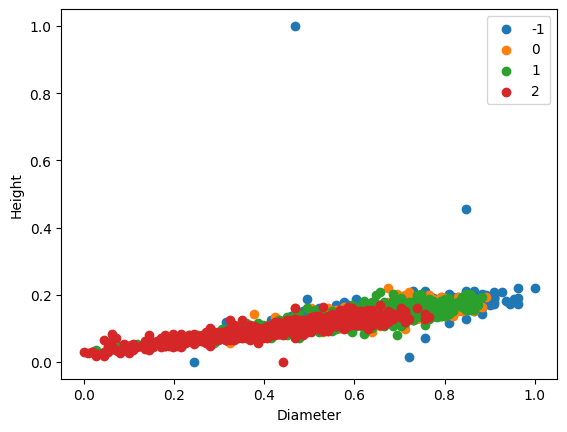

In [19]:
dbscan = DBSCAN(eps=0.1, min_samples=8)
dbscan.fit(X_train_df)
labels = dbscan.fit_predict(X_train_df)

u_labels = np.unique(labels)

for i in u_labels:
    plt.scatter(X_train_df[labels == i]['Diameter'], X_train_df[labels == i]['Height'], label=i)
plt.ylabel('Height')
plt.xlabel('Diameter')
plt.legend()
plt.show()

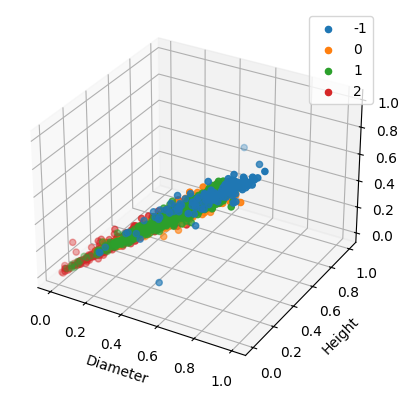

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_labels = np.unique(labels)

for i in u_labels:
    ax.scatter(X_train_df[labels == i]['Diameter'], X_train_df[labels == i]['Height'], X_train_df[labels == i]['Length'], label=i)

ax.set_xlabel('Diameter')
ax.set_ylabel('Height')
ax.set_zlabel('Length')
plt.legend()
plt.show()

### Plot with PCA

#### K-Means

##### 2D

In [21]:
x_pca = PCA(n_components=2).fit_transform(X_train_df)

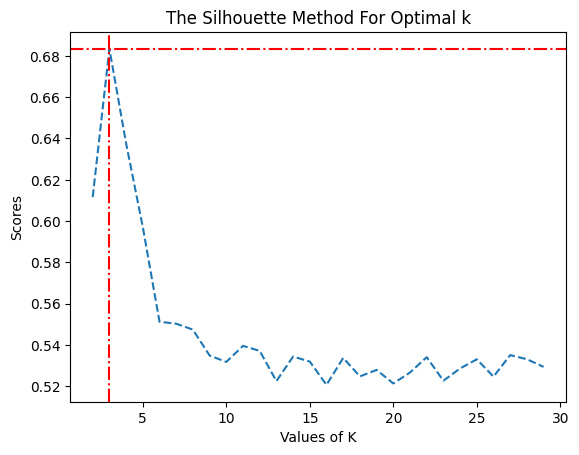

In [22]:
scores = []
K = range(2,30)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(x_pca)
    scores.append(silhouette_score(x_pca, kmeans.labels_))
plt.plot(K, scores, linestyle='--')
plt.xlabel('Values of K') 
plt.ylabel('Scores')
plt.axhline(y=max(scores), color='r', linestyle='-.')
plt.axvline(x=scores.index(max(scores)) + 2, color='r', linestyle='-.')
plt.title('The Silhouette Method For Optimal k')
plt.show()

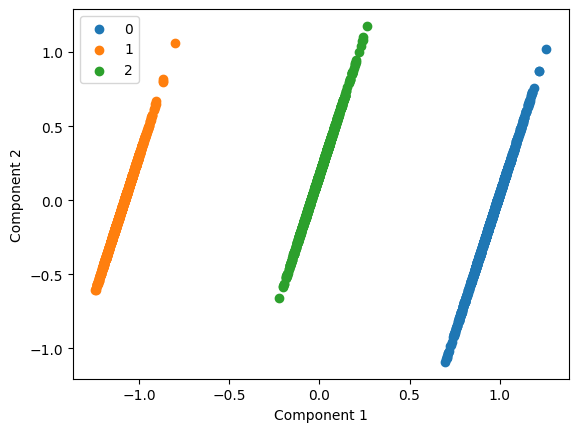

In [23]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_pca)
labels = kmeans.predict(x_pca)

u_labels = np.unique(labels)

for i in u_labels:
    plt.scatter(x_pca[labels == i, 0], x_pca[labels == i, 1], label=i)

plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.legend()
plt.show()

##### 3D

In [24]:
x_pca3 = PCA(n_components=3).fit_transform(X_train_df)

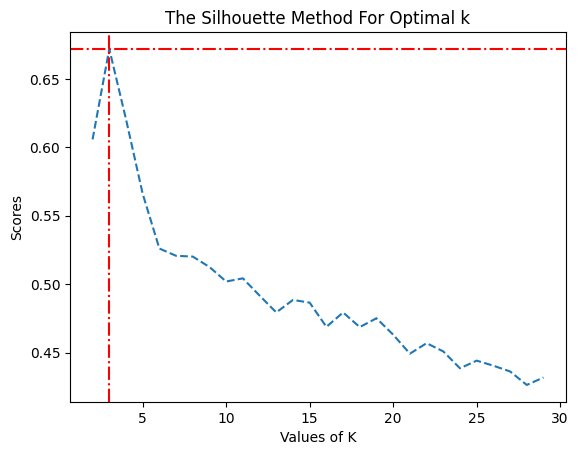

In [25]:
scores = []
K = range(2,30)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(x_pca3)
    scores.append(silhouette_score(x_pca3, kmeans.labels_))
plt.plot(K, scores, linestyle='--')
plt.xlabel('Values of K') 
plt.ylabel('Scores')
plt.axhline(y=max(scores), color='r', linestyle='-.')
plt.axvline(x=scores.index(max(scores)) + 2, color='r', linestyle='-.')
plt.title('The Silhouette Method For Optimal k')
plt.show()

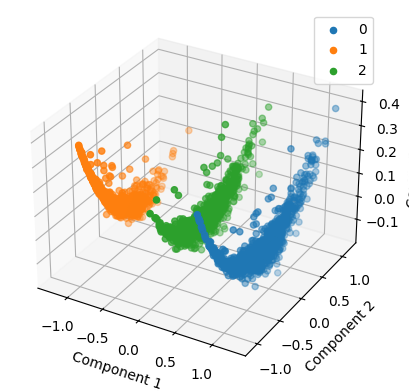

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_pca3)
labels = kmeans.predict(x_pca3)

u_labels = np.unique(labels)

for i in u_labels:
    ax.scatter(x_pca3[labels == i, 0], x_pca3[labels == i, 1], x_pca3[labels == i, 2], label=i)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend()
plt.show()

#### DBSCAN

##### 2D

In [27]:
x_pca = PCA(n_components=2).fit_transform(X_train_df)

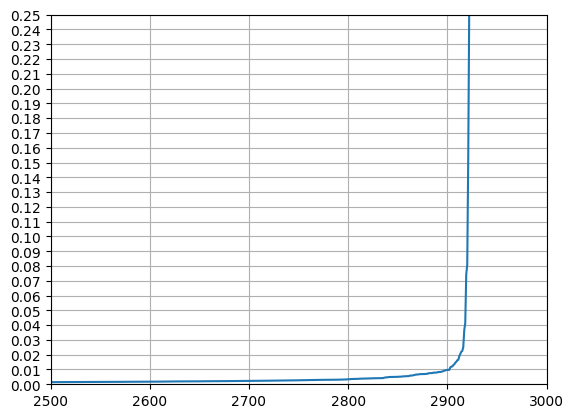

In [28]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(x_pca)
distances, indices = neighbors_fit.kneighbors(x_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlim(2500, 3000)
plt.ylim(0, 0.005)
plt.yticks(np.arange(0, max(distances), 0.01))
plt.grid(True)
plt.show()

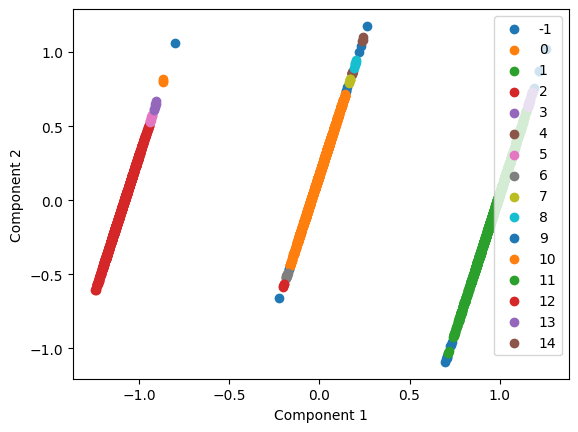

In [29]:
dbscan = DBSCAN(eps=0.02, min_samples=3)
dbscan.fit(x_pca)
labels = dbscan.fit_predict(x_pca)

u_labels = np.unique(labels)

for i in u_labels:
    plt.scatter(x_pca[labels == i, 0], x_pca[labels == i, 1], label=i)

plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.legend()
plt.show()

##### 3D

In [30]:
x_pca3 = PCA(n_components=3).fit_transform(X_train_df)

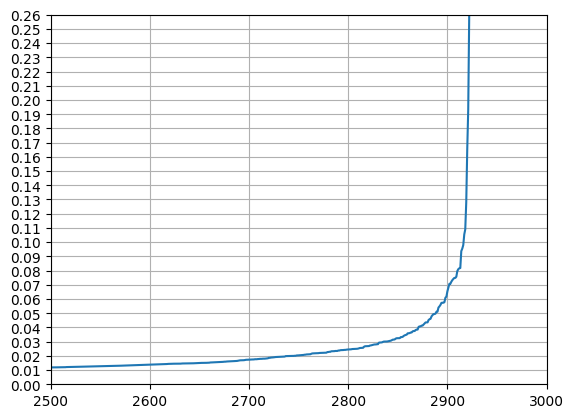

In [31]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(x_pca3)
distances, indices = neighbors_fit.kneighbors(x_pca3)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlim(2500, 3000)
plt.ylim(0, 0.08)
plt.yticks(np.arange(0, max(distances), 0.01))
plt.grid(True)
plt.show()

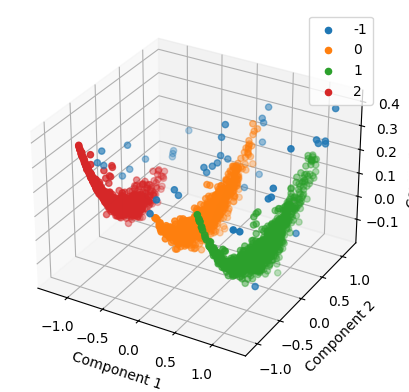

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

dbscan = DBSCAN(eps=0.06, min_samples=4)
dbscan.fit(x_pca3)
labels = dbscan.fit_predict(x_pca3)

u_labels = np.unique(labels)

for i in u_labels:
    ax.scatter(x_pca3[labels == i, 0], x_pca3[labels == i, 1], x_pca3[labels == i, 2], label=i)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend()
plt.show()

### Animations

KMeans

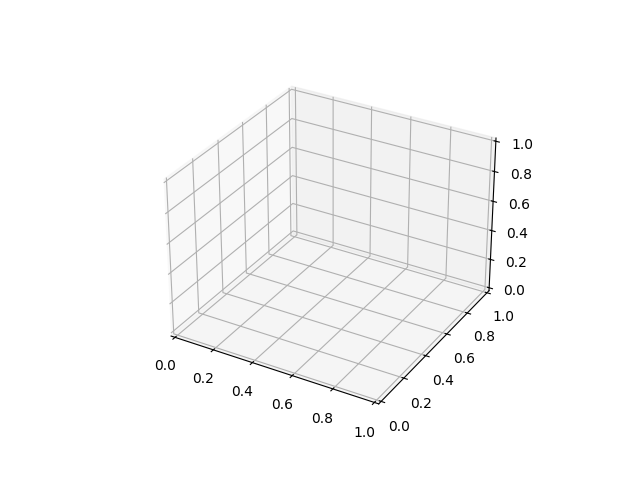

In [33]:
%matplotlib widget
fig_kmeans = plt.figure()
ax_kmeans = fig_kmeans.add_subplot(111, projection='3d')

def animate_kmeans(k):
    ax_kmeans.clear()
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_pca3)
    labels = kmeans.predict(x_pca3)

    u_labels = np.unique(labels)

    for i in u_labels:
        ax_kmeans.scatter(x_pca3[labels == i, 0], x_pca3[labels == i, 1], x_pca3[labels == i, 2], label=i)

    ax_kmeans.set_xlabel('Component 1')
    ax_kmeans.set_ylabel('Component 2')
    ax_kmeans.set_zlabel('Component 3')
    plt.legend()
    ax_kmeans.set_title(f'KMeans with k={k}')

ani_kmeans = animation.FuncAnimation(fig_kmeans, animate_kmeans, frames=range(1, 10), interval=1500)

#### DBSCAN

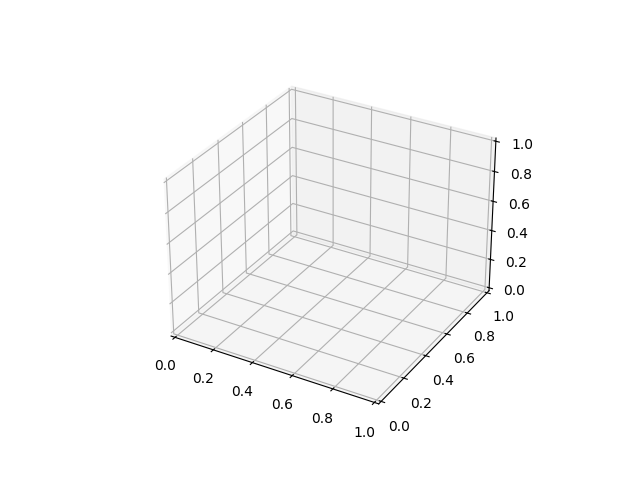

In [34]:
%matplotlib widget
fig_dbscan = plt.figure()
ax_dbscan = fig_dbscan.add_subplot(111, projection='3d')

def animate_dbscan(i):
    ax_dbscan.clear()
    eps = 0.1 + i * 0.1
    dbscan = DBSCAN(eps=eps, min_samples=4)
    dbscan.fit(x_pca3)
    labels = dbscan.fit_predict(x_pca3)

    u_labels = np.unique(labels)

    for i in u_labels:
        ax_dbscan.scatter(x_pca3[labels == i, 0], x_pca3[labels == i, 1], x_pca3[labels == i, 2], label=i)

    ax_dbscan.set_xlabel('Component 1')
    ax_dbscan.set_ylabel('Component 2')
    ax_dbscan.set_zlabel('Component 3')
    # plt.legend()
    ax_dbscan.set_title(f'DBSCAN with eps={eps:.1f}')

ani_dbscan = animation.FuncAnimation(fig_dbscan, animate_dbscan, frames=range(10), interval=2000)

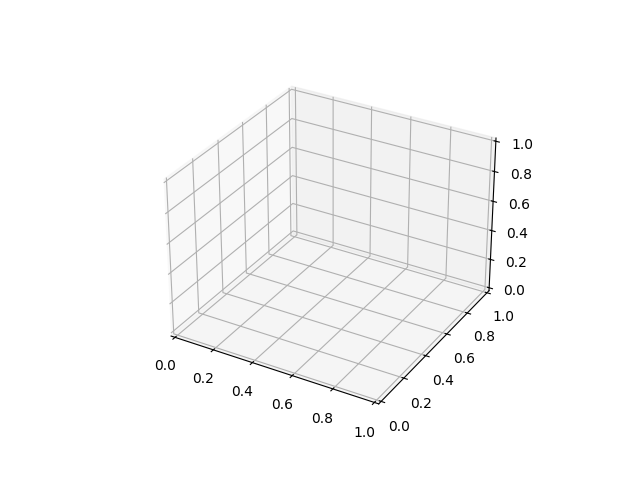

In [35]:
%matplotlib widget
fig_db_sam = plt.figure()
ax_db_sam = fig_db_sam.add_subplot(111, projection='3d')

def animate_db_sam(sm):
    ax_db_sam.clear()
    dbscan = DBSCAN(eps=0.5, min_samples=sm)
    dbscan.fit(x_pca3)
    labels = dbscan.fit_predict(x_pca3)

    u_labels = np.unique(labels)

    for i in u_labels:
        ax_db_sam.scatter(x_pca3[labels == i, 0], x_pca3[labels == i, 1], x_pca3[labels == i, 2], label=i)

    ax_db_sam.set_xlabel('Component 1')
    ax_db_sam.set_ylabel('Component 2')
    ax_db_sam.set_zlabel('Component 3')
    # plt.legend()
    ax_db_sam.set_title(f'DBSCAN with min_samples={sm}')

ani_db_sam = animation.FuncAnimation(fig_db_sam, animate_db_sam, frames=range(1, 1000, 100), interval=2000)